# Classification II: Discriminative models


<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    
- Generative models
- Vector and matrix derivative

</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>
    
- Logistic regression    
- Dimension reduction: Fisher Linear discriminant analysis (F-LDA)

</div>

## Discriminative models

In the previous notebook, we used Bayes' theorem to invert the problem: we focused on the pdf of the observations for each class (generative approach).

In the present notebook we will try to directly estimate the probability of a point $\mathbf x$ to belong to class $C$: $p(C|\mathbf x)$. If we know this probability for all classes, we can then assign an observation to the class that has the maximum probability. This approach is called the *discriminative approach*.

### Logistic regression

Let us consider a simple problem with only 2 classes $C=0$ and $C=1$ and 1 dimension ($x$). In such problem, we have

\begin{equation}
p(C=0|x) = 1- p(C=1|x)
\end{equation}

so we will only consider the probability $y(x) = p(C=1|x)$.

If we know $y(x)$, we can assign a class to each observation

\begin{equation}
C= 
\begin{cases}
1 \quad \rm{if} \quad y(x) >0.5\\
0 \quad \rm{if} \quad y(x) \le 0.5
\end{cases}
\end{equation}

To illustrate the methodology, we will consider the problem for which we are trying to predict whether or not it is a rainy day. We assign a tag 1 for rainy days  and 0 for dry days. 

Since these categories are numerical values, one could very well perform a standard linear regression using the tag as the output variable and the surface pressure a input variable. The figure below illustrates this approach with the ordinary least square method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# load data
df = pd.read_csv("data/era5_paris_sf_2000_2009.csv", index_col='time', parse_dates=True)
# normalize
df_norm = (df - df.mean()) /df.std()
# resample with daily values
df_day = df_norm[['tp', 'sp', 't2m']].resample("D").mean()

# assign tag 
precip_th = -0.2 # normalized threshold
df_day['tag'] = df_day['tp'].where(df_day['tp']> precip_th, 0)
df_day['tag'] = df_day['tag'].where(df_day['tp']<= precip_th, 1)

In [3]:
from sklearn import linear_model

# fit linear regression
ols = linear_model.LinearRegression()
ols.fit(df_day[['sp']], df_day['tag'])

LinearRegression()

Text(0, 0.5, 'Rain tag')

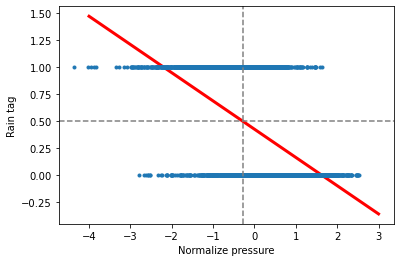

In [4]:
sp_test = np.linspace(-4, 3, 300)
plt.plot(sp_test, ols.coef_ * sp_test + ols.intercept_, 'r', linewidth=3)
plt.plot(df_day['sp'], df_day['tag'], '.')
plt.axhline(.5, linestyle='--', color='.5')
plt.axvline((.5-ols.intercept_)/ols.coef_ , linestyle='--', color='.5')
plt.xlabel('Normalize pressure')
plt.ylabel('Rain tag')

The fit that we obtain is not too bad: there seem to be a tendency for low pressure days to be rainy and high pressure days to be dry. We can use the threshold $y<0.5$ to assign points to the raining category.

This is not fully satisfactory however because $y(x)$ is not restricted to take values between 0 and 1 and so $y$ is not a probability. In order to address this problem, we are going to fit a non-linear function of $x$ called the sigmoid:

\begin{equation}
y(x) = \frac{1}{1 + e^{-x}}
\end{equation}

> ***Question***
> - Check that for any $x$, $0 < y(x) < 1$.
> - For which value of $x$ do we have $y(x) = 0.5$. How would you change that that threshold
> - How could you control the strength of the transition $y\simeq 0$ to $y\simeq 1$

Hence, $y(x)$ can be interpreted as a probability associated to the observation $x$. To make it more generic, we introduce the parameters $\alpha$ and $\beta$ and try to maximize the probability $y(\alpha x + \beta)$ of being in the actual class of the observation $x$.

Because this function is non-linear, we no longer have an analytical solution. We need a non-linear solver to find $\alpha$ and $\beta$. Below is an example on the same data set as above.

In [5]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

Text(0, 0.5, 'Rain tag')

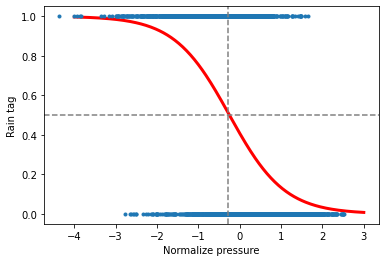

In [6]:
clf = linear_model.LogisticRegression()
clf.fit(df_day[['sp']], df_day['tag'])

loss = sigmoid(sp_test*clf.coef_[0,:] +clf.intercept_)

plt.plot( sp_test, loss, color='red', linewidth=3)
plt.plot(df_day['sp'], df_day['tag'], '.')
plt.axhline(.5, linestyle='--', color='.5')
plt.axvline((.5-ols.intercept_)/ols.coef_ , linestyle='--', color='.5')
plt.xlabel('Normalize pressure')
plt.ylabel('Rain tag')

Note that the threshold $y=0.5$ is actually close to the value we got with simple linear regression. However we can now assign a true probability for the "rain" event given an observation of the pressure. That probability depends on the distance of the observed pressure to the threshold pressure. The variation of this probability depends on the magnitude of $\beta$: for small values of $\beta$, we have a smooth transition between classes whereas for large values of beta, we will have a sharp transition.

Note that the sigmoid function has many interesting properties. For instance we can invert this function to get

\begin{equation}
x = \ln\frac{y}{1 -y}
\end{equation}

where $x$ is now the logarithm of the odds. This function $x(y)$ is called the *logit* function.

Another property is that the derivative of the sigmoid is easy to compute:

\begin{equation}
\frac{dy}{dx} = y(1-y)
\end{equation}

We will use this property when we will study neural networks.

#### Generalization to multiple classes

The example above is relatively straightforward because there are only two classes and we actually took advantage of it when we happily mixed the class identifier and the probability. We can no longer do that when we consider more than two classes. In the multiple class problem the logistic function can be generalized to

\begin{equation}
p(C=k|\mathbf x) = y_k(\mathbf x) = \frac{\exp (\mathbf w_k^\top \mathbf x) }{\sum_i \exp (\mathbf w_i^\top \mathbf x)}
\end{equation}

where $\mathbf w_i$ are $p+1$ dimensional vectors ($p$ features + 1 threshold) which play the same role as $\alpha$ and $\beta$ in the previous example. As before we can use a non linear solver to find the numerical values of the $\mathbf w_i$.

#### Conclusion on logistic regression

Logistic is powerful strategy that does not make any assumption about the distribution of the data in the input space. It provides a probability of belonging to a class. The major drawback of the logistic regression is that, by design, we suppose that there is a linear relationship between the log odds of the output variable and the input variables. This is problematic of course when this relation does not hold...

### Fisher Linear Discriminant Analysis

We have not considered problems with input space of high dimension yet. However, this is often the case that the dimension of the input space is such that it is impossible to visualize the classes. 


Fisher Linear Discriminant Analysis (F-LDA) offers a framework to tackle this problem. This methodology proposed to project the data set into a reduced number of dimension that is best suited to visualize the classes. This dimension reduction method is not only useful for data visualization: it is also a tool to shrink the size of a data set. 

The other popular tool for dimension reduction is *Principal Component Analysis (PCA)* and we will study the latter in the *unsupervised learning* tutorial

To illustrate our point, we are going to use a 2-dimensional data set with two classes $C_1$ and $C_2$. At the end, we will make sure that the strategy we develop can be generalized to higher dimension an a higher number of clusters.

Text(0, 0.5, '$x_2$')

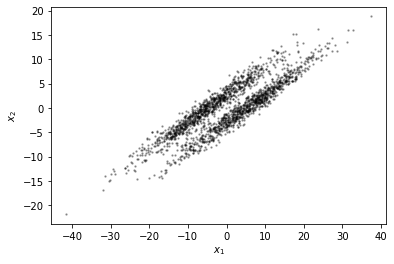

In [7]:
N = 1000
theta = np.pi/6

mu_1 = np.array([-5,0])
mu_2 = np.array([5,0])

sigma_v = np.array([10,1])
Rw = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
Cv = np.diag(sigma_v**2)
Cw = Rw@Cv@Rw.T

z1 = np.random.multivariate_normal(mu_1,Cw, N)
z2 = np.random.multivariate_normal(mu_2,Cw, N)

plt.figure()
plt.scatter(z1[:,0],z1[:,1], s=2, c='k', alpha=0.3)
plt.scatter(z2[:,0],z2[:,1], s=2, c='k', alpha=0.3)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In the example above, we have observations from two distinct and well separated classes. They are indeed well separated because, you can 'by eye' draw the boundaries of these classes. If we now plot a histogram of this data set projected on each dimension $x_1$ and $x_2$, we get the following plot.

Text(0.5, 0, '$x_2$')

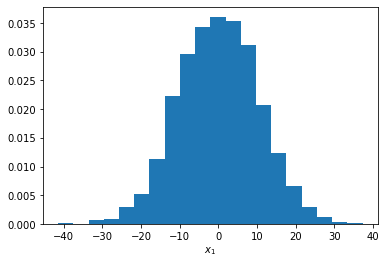

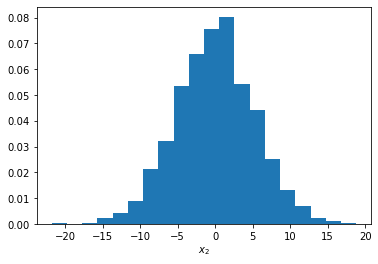

In [8]:
ztot = np.concatenate((z1,z2),0)

plt.figure()
h1 = plt.hist(ztot[:,0],20, density=True)
plt.xlabel(r'$x_1$')

plt.figure()
h2 = plt.hist(ztot[:,1],20, density=True)
plt.xlabel(r'$x_2$')

So in the projection on each axis of the original parameter space $(x_1, x_2)$ is not great because we do not see the clear bi-modal distribution of the data that we spotted *by eye*.

So each of these two dimensions may not be the best available choice to determine the separation line between the classes. We propose instead that there exists another direction $\mathbf w$ that can help us *discriminate* between classes. The idea is that if we project the data onto that direction, 

\begin{equation}
z = \mathbf w^\top \mathbf x
\end{equation}

we get distinct modes in the pdf of $z$. We can then propose a threshold $z_0$ such that if $z>z_0$ we assign a point to class $C_1$ and if $z<z_0$ we assign this point to $C_2$. 

> ***Question***
> - In the example above, do you have an idea of which axis you could use to project the data and get maximum class separability?

In order to find a direction that best separates each cluster, let us first compute the position of the mean of each cluster. In the original coordinate system, the mean of each cluster is given by

\begin{equation}
\mathbf m_1 = \frac{1}{N_1} \sum_{i\in C_1} \mathbf x_i \quad \rm{and} \quad \mathbf m_2 = \frac{1}{N_2} \sum_{i\in C_2} \mathbf x_i
\end{equation}

The projection of these means onto our direction $\mathbf w$ is simply given by 

\begin{equation}
m_1 = \mathbf w^\top \mathbf m_1 \quad \rm{and} \quad m_2 = \mathbf w^\top \mathbf m_2 
\end{equation}

If we want to find the direction $\mathbf w$ that maximizes the distance between each cluster, we define a cost function 

\begin{equation}
J(\mathbf w) = (m_2 - m_1)^2
\end{equation}

> ***Question***
> - Show that 
\begin{equation}
(m_2 - m_1)^2 = \mathbf w^\top \mathbf S_b \mathbf w
\end{equation}

with 

\begin{equation}
\mathbf S_b = (\mathbf m_2 - \mathbf m_1)(\mathbf m_2 - \mathbf m_1)^\top
\end{equation}

the *between* class scatter matrix

The cost function can be arbitrarily big if we take $\mathbf w$ as big as we want. In order to find the direction $\mathbf w$, we need to add a constraint on the norm $\lVert \mathbf w \lVert$ to the cost function.

The new cost function is now

\begin{equation}
J(\mathbf w) = (m_2 - m_1)^2 - \lambda ( \mathbf w^\top \mathbf w - 1)
\end{equation}

with $\lambda$ and external parameter (Lagrange multiplier)

> ***Question***
> - Take the derivative of the cost function with respect to $\mathbf w$ and show that $dJ/d\mathbf w = 0$ when 
\begin{equation}
\mathbf w \propto \mathbf S_b \mathbf w
\end{equation}


However, 
\begin{align}
\mathbf S_b \mathbf w &= (\mathbf m_2 - \mathbf m_1)(\mathbf m_2 - \mathbf m_1)^\top \mathbf w \\
& \propto (\mathbf m_2 - \mathbf m_1)
\end{align}

So $J$ is maximum when 
\begin{equation}
\mathbf w \propto \mathbf m_2 - \mathbf m_1
\end{equation}

That is $\mathbf w$ is the direction that joins the two centers. This does not necessarily ensures that the pdf of points will be well separated when projected onto this axis.

In fact if you examine the code of the example above, you will see that the direction $\mathbf m_2 - \mathbf m_1$ is $x_1$ the first dimension of the data set. And we already saw that projecting the data onto that direction is not very good in terms of class separability.

We introduce another metric that characterizes the spread of the data within each cluster

\begin{equation}
s_1^2 = \sum_{i\in C_1} (\mathbf w^\top \mathbf x_i - m_1)^2 \quad \rm{and} \quad s_2^2 = \sum_{i\in C_2} (\mathbf w^\top \mathbf x_i - m_2)^2
\end{equation}

which is proportional to the variance of each cluster measured on the projection. We want $s_1^2 + s_2^2$ to be as small as possible. 

In a similar way as before, we can show that

\begin{equation}
s_1^2 + s_2^2 = \mathbf w^\top \mathbf S_w \mathbf w
\end{equation}

with $S_w$ the *within* class scatter matrix

\begin{equation}
\mathbf S_w = \sum_{i\in C_1} (\mathbf x_i - \mathbf m_1)(\mathbf x_i - \mathbf m_1)^\top + \sum_{i\in C_2} (\mathbf x_i - \mathbf m_2)(\mathbf x_i - \mathbf m_2)^\top
\end{equation}

which is a measure of the separation of the points within each cluster (whether the spread is high or small).


We define a new cost function that combines these two metrics:

\begin{equation}
J(\mathbf w) = \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2}
\end{equation}

The maximum of this cost function corresponds to the maximum separation of the mean relative to the sample variances. 

We can write the cost function explicitly with the vector $\mathbf w$:

\begin{equation}
J(\mathbf w) = \frac{\mathbf w^\top \mathbf S_b \mathbf w}{\mathbf w^\top \mathbf S_w \mathbf w}
\end{equation}

Again to find the maximum of this cost function we can differenciate it with respect to $\mathbf w$. We find that it is equal to zero when 

\begin{equation}
(\mathbf w^\top \mathbf S_b \mathbf w) \mathbf S_w \mathbf w = (\mathbf w^\top \mathbf S_w \mathbf w) \mathbf S_b \mathbf w 
\end{equation}

> ***Question (optional)***
> - Derive the above formula

Both quantities in parenthesis are scalars so they won't help us find the direction $\mathbf w$.
We can then formulate this problem as a generalized eigenvalue problem

\begin{equation}
\mathbf S_w \mathbf w = \lambda \mathbf S_b \mathbf w 
\end{equation}

And for our particular setting with only 2 clusters, we already saw above that $\mathbf S_b$ is the projection matrix on the direction $\mathbf m_2 - \mathbf m_1$. In that case, we have

\begin{equation}
\mathbf w = \mathbf S_w^{-1} (\mathbf m_2 - \mathbf m_1) 
\end{equation}

where we removed all multiplicative constant. Note that this equation requires that $\mathbf S_w$ is invertible. This condition is usually satisfied when the parameters are independent.

Once we have the direction $\mathbf w$, we can project our data set onto that direction. We have reduced our original two dimensional data set into a 1-dimensional data. In the figure below, we project the data set onto that particular dimension.

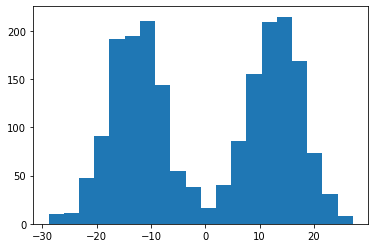

In [9]:
w = np.linalg.solve(Cw,mu_2-mu_1) # we use C_w instead of S_w

z_proj = ztot@w

plt.figure()
hist = plt.hist(z_proj,20)

In this figure, we can see clear mode in the distribution of the data. Not only can we visualize the two classes in a reduced dimensional space, but we can also use that projection to classify the data if we need to.

We can generalize this methodology to any number of cluster $K$ and for $N$ dimensions (provided that $K\le N$). Indeed, because this method was introduced as a dimension reduction method, you always need to have the number of classes that is smaller than the dimension of the problem.

Note also that the maximum number of dimension that you can get out this method is $K-1$.

## References

- Bishop C. M., *Pattern recognition and machine learning*, (2006) Springer

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>